In [1]:
!pip install opencv-python numpy diffusers transformers accelerate

In [92]:
import cv2
import numpy as np

class ImageMosaicExtender:
    def __init__(self, block_size=20, transition_width=40):
        """
        Initialize the mosaic extender with given parameters.

        Args:
            block_size (int): Size of mosaic blocks
            transition_width (int): Width of the smooth transition
        """
        self.block_size = block_size
        self.transition_width = transition_width

    def create_sigmoid_mask(self, size, direction='right'):
      """
      Create a sigmoid-based transition mask with black background and white transition.

      Args:
          size (tuple): Size of the mask (height, width)
          direction (str): Direction of transition ('left', 'right', 'top', 'bottom')

      Returns:
          np.ndarray: A 2D mask with black background and white transition.
      """
      h, w = size
      mask = np.zeros((h, w), dtype=np.float32)

      x = np.linspace(-6, 6, self.transition_width)  # Sigmoid range
      sigmoid = 1 / (1 + np.exp(-x))  # Sigmoid function

      if direction == 'left':
          for i in range(min(w, self.transition_width)):
              mask[:, i] = sigmoid[self.transition_width - i - 1]  # Gradually transition
      elif direction == 'right':
          for i in range(min(w, self.transition_width)):
              mask[:, -(i + 1)] = sigmoid[self.transition_width - i - 1]
      elif direction == 'top':
          for i in range(min(h, self.transition_width)):
              mask[i, :] = sigmoid[self.transition_width - i - 1]
      elif direction == 'bottom':
          for i in range(min(h, self.transition_width)):
              mask[-(i + 1), :] = sigmoid[self.transition_width - i - 1]

      return mask


    def create_mosaic_pattern(self, img_section):
        """
        Create mosaic pattern from an image section.
        """
        h, w = img_section.shape[:2]
        result = np.zeros_like(img_section, dtype=np.float32)

        for y in range(0, h, self.block_size):
            for x in range(0, w, self.block_size):
                y_end = min(y + self.block_size, h)
                x_end = min(x + self.block_size, w)
                block = img_section[y:y_end, x:x_end]
                color = np.mean(block, axis=(0, 1))
                result[y:y_end, x:x_end] = color

        return result

    def extend_image(self, image_path, extensions):
        """
        Extend image with mosaic effect in multiple directions.

        Args:
            image_path (str): Path to input image
            extensions (dict): Dictionary with extension sizes for each direction
                             e.g., {'left': 100, 'right': 200, 'top': 50, 'bottom': 50}
        """
        # Read and convert image to float32 for processing
        img = cv2.imread(image_path).astype(np.float32)
        if img is None:
            raise ValueError("Could not read the image")

        h, w = img.shape[:2]

        # Calculate new dimensions
        new_h = h + extensions.get('top', 0) + extensions.get('bottom', 0)
        new_w = w + extensions.get('left', 0) + extensions.get('right', 0)

        # Create extended image
        extended = np.zeros((new_h, new_w, 3), dtype=np.float32)

        # Position of original image in extended canvas
        y_offset = extensions.get('top', 0)
        x_offset = extensions.get('left', 0)

        # Place original image
        extended[y_offset:y_offset+h, x_offset:x_offset+w] = img



        # Process each direction
        masks = {}
        for direction, size in extensions.items():
            if size == 0:
                continue

            if direction == 'left':
                section = extended[y_offset:y_offset+h, :x_offset]
                base_color = img[:, :1]
            elif direction == 'right':
                section = extended[y_offset:y_offset+h, x_offset+w:]
                base_color = img[:, -1:]
            elif direction == 'top':
                section = extended[:y_offset, x_offset:x_offset+w]
                base_color = img[:1, :]
            else:  # bottom
                section = extended[y_offset+h:, x_offset:x_offset+w]
                base_color = img[-1:, :]

            # Create mosaic pattern
            if direction in ['left', 'right']:
                base = np.tile(base_color, (1, size, 1))
            else:
                base = np.tile(base_color, (size, 1, 1))

            mosaic = self.create_mosaic_pattern(base)

            # Create and store transition mask
            mask = self.create_sigmoid_mask(section.shape[:2], direction)
            masks[direction] = np.expand_dims(mask, axis=2)

            # Apply transition
            if direction == 'left':
                extended[y_offset:y_offset+h, :x_offset] = \
                    mosaic * masks[direction] + base * (1 - masks[direction])
            elif direction == 'right':
                extended[y_offset:y_offset+h, x_offset+w:] = \
                    mosaic * masks[direction] + base * (1 - masks[direction])
            elif direction == 'top':
                extended[:y_offset, x_offset:x_offset+w] = \
                    mosaic * masks[direction] + base * (1 - masks[direction])
            else:  # bottom
                extended[y_offset+h:, x_offset:x_offset+w] = \
                    mosaic * masks[direction] + base * (1 - masks[direction])

        mask_image = np.ones_like(extended, dtype=np.float32)
        mask_image[y_offset:y_offset+h, x_offset:x_offset+w] = np.zeros_like(img)
        cv2.imwrite('mask_image.jpg', (mask_image * 255).astype(np.uint8))
        return extended.astype(np.uint8)


def process_image(input_path, output_path, extensions, block_size=20, transition_width=40):
    """
    Process and save image with mosaic extensions.

    Args:
        input_path (str): Path to input image
        output_path (str): Path to save result
        extensions (dict): Dictionary with extension sizes for each direction
        block_size (int): Size of mosaic blocks
        transition_width (int): Width of the smooth transition
    """
    processor = ImageMosaicExtender(block_size, transition_width)
    result = processor.extend_image(input_path, extensions)
    cv2.imwrite(output_path, result)

# Example usage
if __name__ == "__main__":
    input_path = "/content/second-sample-image.jpg"
    output_path = "output_image.jpg"

    # Example: extend image in multiple directions
    extensions = {
        'right': 200,  # 100 pixels to the right
        'left': 200,   # 100 pixels to the left
        'top': 00,    # 100 pixels to the top
        'bottom': 000  # 100 pixels to the bottom
    }

    process_image(
        input_path,
        output_path,
        extensions,
        block_size=20,
        transition_width=40
    )

In [41]:
img = cv2.imread('/content/output_image.jpg')
h,w = img.shape[:2]

In [100]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

def inpaint_image(input_image_path, mask_image_path):
  """
  Inpaint an image using a pre-trained diffusion model.

  Args:
    input_image_path (str): Path to the input image.
    mask_image_path (str): Path to the mask image.

  Returns:
    PIL.Image: The inpainted image.
  """
  output_size=(1024, 1024)
  prompt="fill the background color very consious and perfectly"
  guidance_scale=8.0
  num_inference_steps=20 
  strength=0.99
  seed=0
  pipe = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16").to("cuda")

  input_image = load_image(input_image_path)
  mask_image = load_image(mask_image_path)

  w,h = input_image.size
  resize_input_image = input_image.resize(output_size)
  resize_mask_image = mask_image.resize(output_size)

  generator = torch.Generator(device="cuda").manual_seed(seed)

  inpainted_image = pipe(
    prompt=prompt,
    image=resize_input_image,
    mask_image=resize_mask_image,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    strength=strength,
    generator=generator,
  ).images[0]

  return inpainted_image.resize((w,h))

# Example usage
img_url = "/content/output_image.jpg"
mask_url = "/content/mask_image.jpg"
image = inpaint_image(img_url, mask_url)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
image

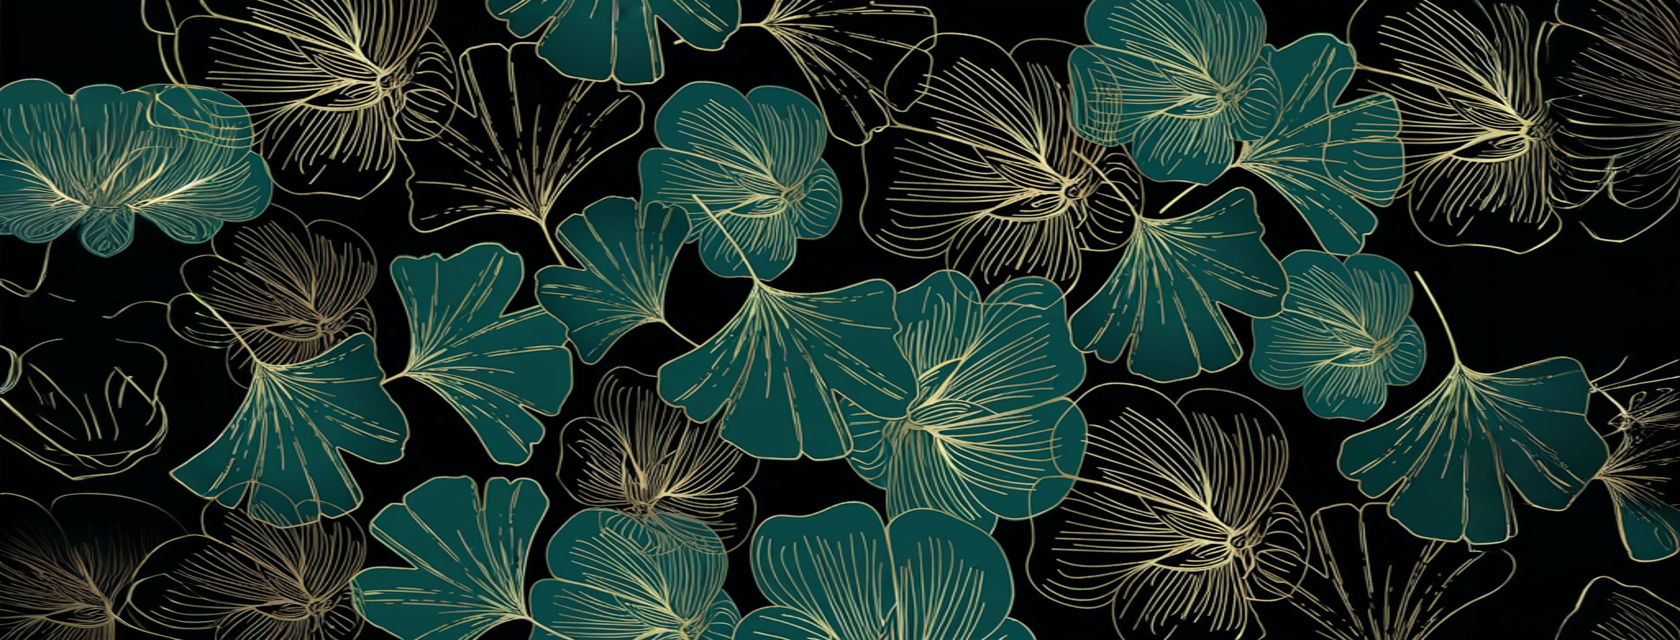

In [101]:
output_image = load_image(image)
w, h = input_image.size
output_image.resize((w, h))

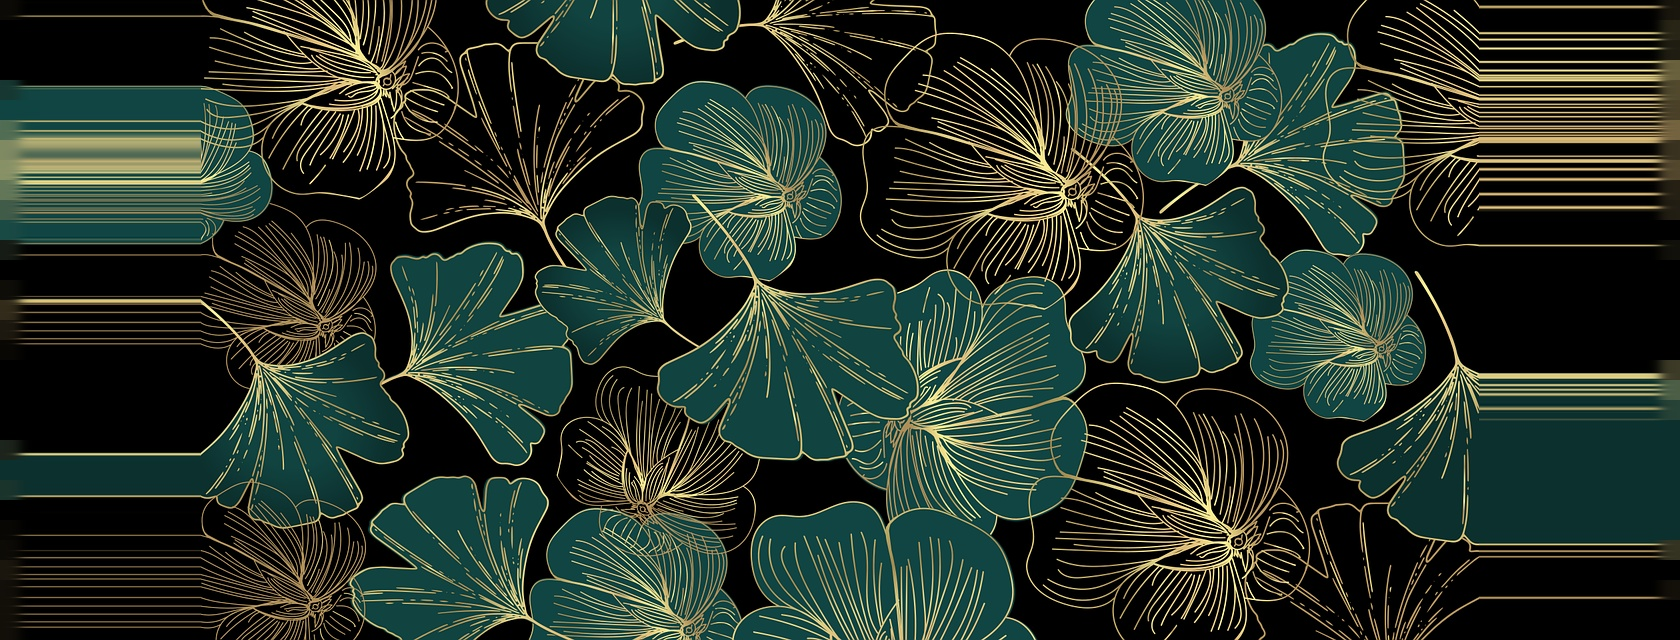

In [102]:
input_image

In [ ]:
import gradio as gr
import numpy as np

# Define a function that takes an image and several checkboxes and a slider as input
# and returns the image twice as output. The function currently does not use the checkboxes or slider.
def greet(input_image, direction, pixel_extended):
    return input_image, input_image

# Define a function that takes two images as input and returns a new image
def process_images(image1, image2):
    # Combine the two images in some way (for demonstration, we'll just return the first image)
    return image1

# Create a Gradio Interface with the greet function
# The inputs include an image, a radio button for direction, and a slider
# The outputs are two images
with gr.Blocks() as demo:
    input_image = gr.Image(label="Upload Image")
    direction = gr.Radio(choices=['left', 'right', 'up', 'down'], label="Direction")
    pixel_extended = gr.Slider(0, 200, label="Pixel Extension", info="Choose between 0 and 200")
    output_image1 = gr.Image(label="Masked Image")
    output_image2 = gr.Image(label="Mosaic Image")
    final_output_image = gr.Image(label="Final Processed Image")

    # Create a timer that triggers the greet function 2 seconds after the slider value changes
    timer = gr.Timer(2, active=False)
    pixel_extended.change(lambda: gr.Timer(active=True), None, timer)
    timer.tick(greet, [input_image, direction, pixel_extended], [output_image1, output_image2])

    # Create a button to process the images
    process_button = gr.Button("Process Images")
    process_button.click(process_images, [output_image1, output_image2], final_output_image)

demo.launch(show_error=True)